# Surfeando la ola más grande de la historia

El 9 de julio de 1958, en la bahía de Lituya (Alaska), un fuerte sismo provocó que se derrumbaran más de 30 millones de metros cúbicos de rocas del glaciar Lituya hacia el fondo de la bahía. Como resultado, se generó la ola más grande registrada en la historia, con una altura de 520 metros. Un lugareño llamado Howard Uhlrich y su hijo, que estaban en ese momento en la bahía pescando, consiguieron evitar que la ola los hundiera remontándola con su pequeña embarcación.

Ahora simularemos qué pasaría si intentamos recrear esta situación con una tabla de surf. Aunque los cálculos sean relativamente sencillos, el notebook nos permitirá cambiar parámetros y hacer predicciones cuantitativas de forma rápida.

En primer lugar cargamos la librería Numpy, especializada en el cálculo numérico y el análisis de datos, y la librería Matplotlib, para la representación gráfica

In [115]:
import numpy as np
import matplotlib.pylab as plt

Definamos las cantidades necesarias para llevar a cabo nuestros cálculos.

Comenzamos con la velocidad de la ola. No hay datos de qué velocidad alcanzó la ola de 1958 pero en el año 2015 hubo un suceso similar, también en Alaska. Un desprendimiento generó una ola de 200 metros de altura, con una velocidad de unos 100 km/h. Dado que nuestra ola es más del doble de grande, supondremos que las rocas lograron imprimirle una velocidad de unos 200 km/h.

En segundo lugar, tenemos la masa del sistema, en este caso será el surfista más la tabla de surf. Tomando valores típicos, estimamos unos 70 kg.

Uno de los parámetros libres más importantes será el porcentaje de la ola que queramos que el surfista ascienda, el cual no deberá ser superior al 80% (de forma estimada). Hay dos motivos: en primer lugar, la ola se curva hacia adelante en la parte superior, así que el surfista se caería con total probabilidad si ascendiera tanto; en segundo lugar, a continuación aproximaremos la superficie de la ola como una función matemática, y tanto en la región inferior como en la región media-alta respeta bastante fielmente la forma original, no así en la parte superior. La altura que trataremos en los cálculos será por tanto la altura total de la ola (parámetro fijo) por el porcentaje que queramos que el surfista ascienda.


In [116]:
Velocidad_ola = 200*(1000/3600) #factor de conversión de la velocidad de la ola al sistema internacional, m/s
m = 70 #kg (masa del surfista + masa de la tabla)
g = 9.81 #m/s^2
altura_ola = 500 #m
porcentaje_ola_subida = 0.75
h = porcentaje_ola_subida*altura_ola

Suponemos aquí que la ola no pierde energía cuando impacta contra el surfista, es decir, el conjunto ola+surfista conserva la energía cinética que traía la ola previamente, suposición muy razonable debido a la diferencia de tamaño entre ambos.
Un vez es alcanzado por ella, adquiere una energía potencial por el hecho de ascender por la pared hasta una altura $\textbf{h}$. Supongamos que esta pared es un plano inclinado (que se va curvando) con un ángulo $\textbf{$\alpha$}$. En el siguiente esquema se representa el diagrama de fuerzas en un punto de la superficie arbitrario.

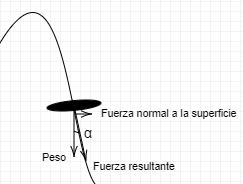

Este ángulo es una función de la posición y será de gran relevancia, pues permite ir comparando punto a punto la aceleración gravitacional sobre el surfista con la deceleración por el rozamiento superficial. Tanto para definir el ángulo como estas fuerzas, necesitamos un punto de partida y un punto final. El punto de partida dependerá de la altura, es decir, del porcentaje de ola que queramos el surfista ascienda. El punto final simplemente será el punto en el que la superficie sea (prácticamente) horizontal. Aproximamos dicha superficie por una exponencial decreciente unidimensional (no dejaremos que el surfista se mueva lateralmente). El factor 1/10 lo introducimos para "aplanar" la superficie exponencial y medir x en metros. De esta forma, las dimensiones transversales de la ola (su ancho) no son despreciables comparadas con su altura (para 500 metros de altura, el ancho es más de un 10% del alto).

$$ \left.\begin{matrix}
f(x) = e^{-x/10}\\ f(t=0) = f(x_{i}) = h
\end{matrix}\right\} \Rightarrow x_{i} = -10\ln(h) $$

In [117]:
xi = -10*np.log(h) #punto inicial
xf = 35 #punto final (en x = 35 m la exponencial casi es plana comparada con las dimensiones de la ola)

Definamos $\alpha$, el ángulo que se forma entre la tangente a la superficie y la vertical en cada punto de la ola. Para ello, usamos que la derivada nos da la pendiente de la recta tangente en cada punto:

$$ \frac{df}{dx} = \tan (\alpha - \frac{\pi}{2}) \Rightarrow \alpha (x) = \frac{\pi}{2} + \arctan(\frac{df}{dx}) $$

In [118]:
x = np.linspace(xi,xf,10000)
sup = np.exp(-x/10)
derivada = (-1/10)*sup
alfa = (np.pi/2) + np.arctan(derivada)

Corregimos con $-\frac{\pi}{2}$ el argumento de la tangente porque la derivada es sobre el ángulo complementario a $\alpha$. Una vez caracterizamos $\alpha (x)$, veamos el balance de fuerzas.

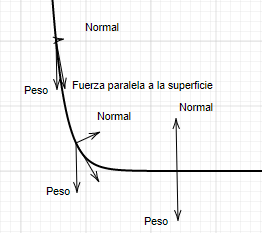

La fuerza normal a la superficie, la responsable de que la tabla se mantenga a flote, será igual en magnitud a la componente ortogonal del peso a la superficie en cada punto de la ola. El peso se mantiene constante ya que solo depende de la fuerza gravitatoria, mientras que la normal varía alcanzando su máximo (igual al peso) en la superficie plana. Por lo tanto, la normal solo dependerá del ángulo entre el vector peso y el vector tangencial a la superficie, es decir, $\alpha$.

In [119]:
Peso = m*g #efecto de la gravedad sobre el cuerpo
Normal = Peso*np.sin(alfa) #respuesta de la superficie frente al peso

La fuerza de rozamiento es directamente proporcional a la fuerza normal y a un parámetro denominado coeficiente de rozamiento, que depende fuertemente de la viscosidad de la superficie y que generalmente también depende de la presión aplicada sobre esta. Aquí, por simplicidad, lo consideraremos constante.

In [120]:
mu = 0.1 #coeficiente de rozamiento
Fuerza_rozamiento = -mu * Normal #el signo - indica que se opone al movimiento

Hagamos el tratamiento análogo a la fuerza de rozamiento con la componente paralela a la superficie del peso.

In [121]:
Fuerza_paralela = Peso*np.cos(alfa)

Definamos entonces una fuerza neta en cada punto para determinar el balance de energías. En virtud del teorema del trabajo-energía cinética, el trabajo realizado por la fuerza neta aplicada a una partícula es igual al cambio que experimenta la energía cinética de dicha partícula:

$$\Delta E = E_{x_{f}} - E_{x_{i}}= \int_{x_{i}}^{x_{f}} F_{neta} dx$$

In [122]:
Fuerza_neta = Fuerza_paralela + Fuerza_rozamiento

Si desarrollamos la ecuación integral para obtener una ecuación diferencial, podremos resolverla de forma iterativa:

$$\Delta E = \int F dx \quad \longrightarrow \quad \frac{d\Delta E}{dx} = \frac{d}{dx}\left[\int F dx \right] = F(x) \quad \longrightarrow \quad F = \frac{d\Delta E}{dx} = \lim_{h\rightarrow 0}\frac{\Delta E(x+h)-\Delta E(x)}{h}$$

El límite se puede escribir y manipular de la siguiente forma dentro de un bucle iterativo (cambiando la variable x por el índice i) para valores pequeños de h:

$$\Delta E[i+1] \sim \Delta E[i] + hF[i] \quad \longrightarrow \quad \Delta E[i] \sim \Delta E[i-1] + hF[i-1] \qquad (h <<)$$

Bajo este esquema de integración tanto el valor del intervalo h, los límites de integración $x_{i}$ y $x_{f}$ y el número de iteraciones n están ligados bajo la condición:

$$n = 1 + \frac{x_{f} - x_{i}}{h}$$

Teniendo este procedimiento en cuenta, calculamos la energía de forma iterativa. Una vez la tenemos, podemos calcular la velocidad y la aceleración en cada punto:

$$E = \frac{1}{2} m v^{2} \longrightarrow v = \sqrt{\frac{2E}{m}} \longrightarrow v[i] = \sqrt{\frac{2E[i]}{m}}$$

$$a = \frac{dv}{dt} = \frac{dv}{dx}\frac{dx}{dt} = v \frac{dv}{dx} \longrightarrow a[i] = v[i]\left(v[i] - v[i-1]\right)$$

donde en el último caso aproximamos la derivada por la diferencia entre velocidades en iteraciones consecutivas.

In [123]:
h=0.01
n=int(1+(xf-xi)/h)
dE = [0]*n
dv = [0]*n
da = [0]*n
i = 0
for i in range(1,n-1):
    dE[i+1] = dE[i] + h*Fuerza_neta[i]
    dv[i+1] = np.sqrt(2*dE[i+1]/m)
    da[i+1] = dv[i+1]*(dv[i+1]-dv[i])
    i = i+1

Una vez tenemos las cantidades calculadas y almacenadas en listas, podemos despejar la velocidad final a partir de la energía cinética:

$$\Delta E = \int ^{x_{f}} _{x_{i}} F_{neta} dx = \frac{1}{2}mv_{f}^{2} \quad \longrightarrow \quad v_{f} = \sqrt{\frac{2 \Delta E}{m}}$$

Sumamos la contribución de la velocidad de la ola e imprimimos el resultado.

In [125]:
Energia_final = dE[n-1]
Velocidad_ganada = np.sqrt(2 * Energia_final/m)
Velocidad_total = (Velocidad_ola + Velocidad_ganada)*3.6 #factor de conversión de m/s a km/h
print('El surfista habrá adquirido una velocidad aproximada de {:.0f} km/h cuando llega a la parte inferior de la ola. La velocidad total tiene en cuenta la propia velocidad que trae la ola, resultando {:.0f} km/h.'.format(Velocidad_ganada*3.6, Velocidad_total))

El surfista habrá adquirido una velocidad aproximada de 100 km/h cuando llega a la parte inferior de la ola. La velocidad total tiene en cuenta la propia velocidad que trae la ola, resultando 300 km/h.


Teniendo en cuenta que el record guiness de velocidad sobre una tabla de surf es de unos 80 km/h, parece que nuestra ola sería bastante difícil de surfear. El surfista debería tener la fuerza suficiente para compensar la resistencia del aire, además de las fuerzas laterales que se darían por la no uniformidad de la superficie de la ola, por eso parece poco probable que pudiera ser posible surfear la ola más grande de la historia.

Uhlrich y su hijo se libraron de esta gran ola remontándola de forma frontal, la forma más "segura" de actuar en estos casos. Suponiendo que su embarcación es capaz de soportar velocidades de unos 300 km/h sin volcar y decidieran darle la espalda y acelerar su embarcación, es decir, surfear la ola sin que esta rompa, según nuestros cálculos (aún modificando el rozamiento del barco con el agua), ¡podrían haber sobrevivido igualmente!

También cabe destacar que la mayor parte de la velocidad final es la propia velocidad que trae la ola. Al ser generadas por fuerzas tan bruscas e instensas, este tipo de olas glaciares adquieren unas velocidades muy grandes. Por lo tanto, la mayor dificultad a la que se enfrenta el surfista no sería tanto la altura de la ola como la velocidad de la misma.

Ahora representemos el los perfiles de energía, velocidad y aceleración. Para ello, debemos imprimir las listas de valores que hemos calculado con el bucle. Además, debemos introducir un reescalado en el eje horizontal para que, en lugar de representar las iterciones, representemos la distacia en metros (ya que hemos iterado 100 veces por cada metro).

In [126]:
numeroiteraciones = range(0,i)
posicion = list(numeroiteraciones)
escalado = 100
posicion = list(map(lambda x: x / escalado, posicion))
#map: recibe una función que va a ejecutarse por cada miembro de la lista de elementos y retorna un nuevo elemento 
#con el resultado

Calculamos también el máximo de energía, es decir, cuando la fuerza de rozamiento supera en módulo a la fuerza de la gravedad, y lo representamos gráficamente (en rojo).

In [132]:
j = 0
for j in range(1,n-1):
    if abs(Fuerza_rozamiento[j]) > abs(Fuerza_paralela[j]):
        break
x_max = j / 100
v_Emax = dv[j]
a_Emax = da[j]

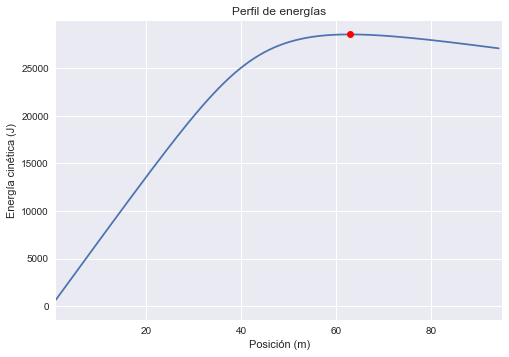

In [133]:
plt.plot(posicion,dE[0:i])
plt.plot(x_max, max(dE), 'or')
plt.style.use('seaborn')
plt.xlabel("Posición (m)")
plt.xlim(1,95)
plt.ylabel("Energía cinética (J)")
plt.title('Perfil de energías')
plt.grid(True)
plt.show(True)

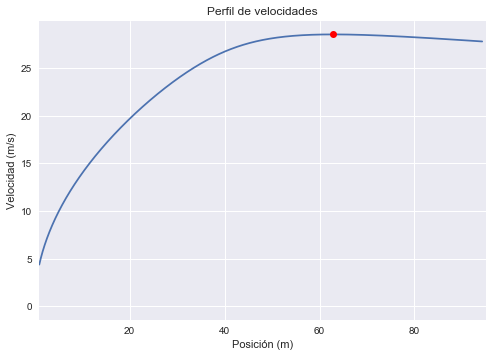

In [134]:
plt.plot(posicion,dv[0:i])
plt.plot(x_max, v_Emax, 'or')
plt.style.use('seaborn')
plt.xlabel("Posición (m)")
plt.xlim(1,95)
plt.ylabel("Velocidad (m/s)")
plt.title('Perfil de velocidades')
plt.grid(True)
plt.show(True)

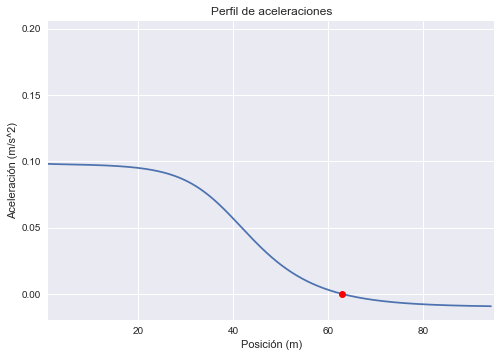

In [135]:
plt.plot(posicion,da[0:i])
plt.plot(x_max, a_Emax, 'or')
plt.style.use('seaborn')
plt.xlabel("Posición (m)")
plt.xlim(1,95)
plt.ylabel("Aceleración (m/s^2)")
plt.title('Perfil de aceleraciones')
plt.grid(True)
plt.show(True)

---------------------

$\textbf{Nota sobre el coeficiente de rozamiento:}$ además de que estamos utilizando una primera aproximación respecto a la fuerza de fricción entre dos superficies, el agua no posee un coeficiente de rozamiento dinámico como tal. Se trata de un fluido, así que tanto la fricción de nuestro surfista con el agua como con el aire se deberían tratar desde un estudio de dinámica de fluidos. Deberíamos definir un coeficiente de resistencia $C$ (aerodinámico e hidrodinámico) y, para las velocidades tratadas, tratar una fuerza de rozamiento proporcional a $C$ y al cuadrado de la velocidad. Este tipo de tratamiento, además de por la ausencia de datos y la falta de realidad de la situación, es extremedamente complejo. Hemos optado entonces por definir una superficie tabla-agua que se comporta en cuestiones de fricción como la de dos sólidos rígidos desplazándose uno respecto al otro y hemos definido un coeficiente de rozamiento dinámico para esta superficie con un valor menor a valores típicos que hemos encontrado como el de la madera ($\mu \sim$ 0,4) o el del acero ($\mu \sim$ 0,16). Teniendo en cuenta estos datos y la fricción con el aire a altas velocidades, el valor de $\mu$ es de 0,1.